In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/MSc_project/.MAIN

Mounted at /content/drive
/content/drive/My Drive/MSc_project/.MAIN


In [ ]:
!pip install pandas==1.2.4
!pip install xgboost
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 2.7 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os.path

import nltk
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, Booster
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split


In [ ]:
import xgboost
print(xgboost.__version__)

0.90


In [ ]:
df=pd.read_csv('user_gender_class/data/gender-classifier-DFE-791531.csv',encoding='latin1')

df.drop(['_unit_id','_last_judgment_at','created','fav_number','profileimage','retweet_count','tweet_coord',
         '_trusted_judgments', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone', 
         '_golden','_unit_state', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'sidebar_color', 
         'profile_yn', 'profile_yn:confidence','gender:confidence'], axis=1, inplace=True)

df.isna().sum()
df.dropna(axis=0,inplace=True)
df['gender'].value_counts()
df['gender'] = df[(df['gender'] == 'female') | (df['gender'] == 'male')]
df['gender'].value_counts()

female    5725
male      5469
Name: gender, dtype: int64

In [ ]:
for gen in df['gender']:
  #print(gen)
  if gen=='male':
    df['gender'].replace({'male':'1'},inplace=True)
  elif gen=='female':
    df['gender'].replace({'female':'0'},inplace=True)

df['gender'].value_counts()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(review):
    descrip = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    return review


df['descrip_Cleaned'] = pd.DataFrame(df['description'].apply(lambda x: clean(x)))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,gender,description,text,descrip_Cleaned
0,1,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.
1,1,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,i'm the author of novels filled with family dr...
2,1,louis whining and squealing and all,i absolutely adore when louis starts the songs...,louis whining and squealing and all
3,1,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,"mobile guy. 49ers, shazam, google, kleiner pe..."
4,0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,ricky wilson the best frontman/kaiser chiefs t...


## Cleaning the Twitter Data

In [ ]:
df['descrip_Cleaned'].replace('[@+]', "", regex=True,inplace=True)
df['descrip_Cleaned'].replace('[()]', "", regex=True,inplace=True)
url_regex = "(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
df['descrip_Cleaned'] = df['descrip_Cleaned'].replace(url_regex, "", regex=True)

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')

# remove all tokens that are not alphabetic
df['descrip_Cleaned'] = [nltk.word_tokenize(tweet) for tweet in df['descrip_Cleaned']]

descrip_new=[]
for each_row in df['descrip_Cleaned']:
    descrip_new.append([i for i in each_row if i.isalpha()])

descrip_new_alpha=[]
stop_words = set(stopwords.words('english'))
for each_row in descrip_new:
    descrip_new_alpha.append([i for i in each_row if i not in stop_words])

description_new_lemma = []
lemma = nltk.WordNetLemmatizer()
for each_row in descrip_new_alpha:
    description_new_lemma.append([lemma.lemmatize(word) for word in each_row])

df.tail()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,gender,description,text,descrip_Cleaned
20045,0,(rp),"@lookupondeath ...Fine, and I'll drink tea too...",[rp]
20046,1,"Whatever you like, it's not a problem at all. ...",Greg Hardy you a good player and all but don't...,"[whatever, you, like, ,, it, 's, not, a, probl..."
20047,1,#TeamBarcelona ..You look lost so you should f...,You can miss people and still never want to se...,"[#, teambarcelona, .., you, look, lost, so, yo..."
20048,0,Anti-statist; I homeschool my kids. Aspiring t...,@bitemyapp i had noticed your tendency to pee ...,"[anti-statist, ;, i, homeschool, my, kids, ., ..."
20049,0,Teamwork makes the dream work.,I think for my APUSH creative project I'm goin...,"[teamwork, makes, the, dream, work, .]"


In [ ]:
df['descrip_Cleaned'] = description_new_lemma
df['descrip_Cleaned'] = [" ".join(desc) for desc in df['descrip_Cleaned'].values]

df.tail()

def clean1(review1):
    descrip = re.sub('[^a-zA-Z]', ' ', review1)
    review1 = review1.lower()
    return review1

df['text_Cleaned'] = pd.DataFrame(df['text'].apply(lambda y: clean1(y)))
df.head()

,gender,description,text,descrip_Cleaned,text_Cleaned
0,1,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,sing rhythm,robbie e responds to critics after win against...
1,1,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,author novel filled family drama romance,ûïit felt like they were my friends and i was...
2,1,louis whining and squealing and all,i absolutely adore when louis starts the songs...,louis whining squealing,i absolutely adore when louis starts the songs...
3,1,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,mobile guy shazam google kleiner perkins yahoo...,hi @jordanspieth - looking at the url - do you...
4,0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,ricky wilson best chief best band xxxx thank k...,watching neighbours on sky+ catching up with t...


In [ ]:
df.shape

(16224, 5)

In [ ]:
df['text_Cleaned'].replace('[@+]', "", inplace=True)
df['text_Cleaned'].replace('[()]', "", inplace=True)
df['text_Cleaned']=df['text_Cleaned'].replace('[#+]', "", regex=True)
url_regex = "(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
df['text_Cleaned'] = df['text_Cleaned'].replace(url_regex, "", regex=True)
df['text_Cleaned'] = [nltk.word_tokenize(tweet) for tweet in df['text_Cleaned']]
text_new=[]
for each_row in df['text_Cleaned']:
    text_new.append([i for i in each_row if i.isalpha()])

text_new_alpha=[]
stop_words = set(stopwords.words('english'))
for each_row in text_new:
    text_new_alpha.append([i for i in each_row if i not in stop_words])

text_new_lemma = []
lemma = nltk.WordNetLemmatizer()
for each_row in text_new_alpha:
    text_new_lemma.append([lemma.lemmatize(word) for word in each_row])
df['text_Cleaned'] = text_new_lemma
df['text_Cleaned'] = [" ".join(desc) for desc in df['text_Cleaned'].values]

In [ ]:
df.head()

,gender,description,text,descrip_Cleaned,text_Cleaned
0,1,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,sing rhythm,robbie e responds critic win eddie edward worl...
1,1,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,author novel filled family drama romance,felt like friend living story retired
2,1,louis whining and squealing and all,i absolutely adore when louis starts the songs...,louis whining squealing,absolutely adore louis start song hit hard fee...
3,1,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,mobile guy shazam google kleiner perkins yahoo...,hi jordanspieth looking url use ifttt typicall...
4,0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,ricky wilson best chief best band xxxx thank k...,watching neighbour sky catching neighbs xxx xxx


In [ ]:
# df.drop(['description','text'],axis=1,inplace=True)
# df.head()

cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(df['descrip_Cleaned']).toarray()

x1 = cv.fit_transform(df['text_Cleaned']).toarray()

A=pd.DataFrame(x)
B=pd.DataFrame(x1)

X= pd.concat([B, A], join = 'outer', axis = 1)


df['gender'].isnull().sum()

df['gender'].fillna(df['gender'].mode()[0], inplace=True)

In [ ]:
x = np.array(X)
y = np.array(df['gender'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

## Training

In [ ]:
import pickle

xgbmodel = XGBClassifier(max_depth=5, min_child_weight=1)
xgbmodel.fit(X_train, y_train)

y_pred2 = xgbmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2)

Accuracy: 69.28%


array([[2101,   44],
       [ 953,  147]])

In [ ]:
filename = 'user_gender_class/model/xgb_gender.dat'
pickle.dump(xgbmodel, open(filename, "wb"))

In [ ]:
# xgbmodel.save_model('user_gender_class/model/xgb_gender.json')
# filename = 'user_gender_class/model/xgb_gender.json'
# # pickle.dump(xgbmodel, open(filename, 'wb'))

In [ ]:
len(y_pred2)

3245

In [ ]:
xmodel = pickle.load(open(filename, 'rb'))

y_pred2 = xmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2)

Accuracy: 69.31%


array([[2094,   51],
       [ 945,  155]])

In [ ]:
from xgboost import DMatrix

xmodel = XGBClassifier(max_depth=5, min_child_weight=1)
booster = Booster()
booster.load_model('user_gender_class/model/xgb_gender.json')
xmodel._Booster = booster

y_pred2 = xmodel.predict(DMatrix(X_test))

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2)

NameError: ignored

In [ ]:
## FINDING BEST XGB

xgb_param_grid = {
              "max_depth": [3, 5],
              "min_child_weight": [1, 2],
              }

xgbgrid = GridSearchCV(estimator = xgbmodel, param_grid = xgb_param_grid, cv = 3, n_jobs = -1, verbose = 0)

xgbgrid.fit(X_train, y_train)

xgbgrid.best_params_

y_pred2_hyper = xgbgrid.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2_hyper)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2_hyper)

Accuracy: 69.31%


array([[2094,   51],
       [ 945,  155]])

## UNNEEDED CODE

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnbmodel = GaussianNB()
gnbmodel.fit(X_train , y_train)
# GaussianNB()
# from sklearn.naive_bayes import GaussianNB
y_pred = gnbmodel.predict(X_test)

In [ ]:
len(y_pred)

3245

In [ ]:
len(y_test)

3245

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.05%


In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 759, 1386],
       [ 170,  930]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))





              precision    recall  f1-score   support

           0       0.82      0.35      0.49      2145
           1       0.40      0.85      0.54      1100

    accuracy                           0.52      3245
   macro avg       0.61      0.60      0.52      3245
weighted avg       0.68      0.52      0.51      3245



In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nbModel_grid = GridSearchCV(estimator=gnbmodel, param_grid=param_grid_nb, verbose=1, cv=3, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
#print(nbModel_grid.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=1)

In [ ]:
nbModel_grid.best_params_

{'var_smoothing': 0.02310129700083159}

In [ ]:
y_pred_hyper = nbModel_grid.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_hyper), ": is the confusion matrix")
from sklearn.metrics import accuracy_score
accuracy_gnb_hyper = accuracy_score(y_test, y_pred_hyper)
print("Accuracy: %.2f%%" % (accuracy_gnb_hyper * 100.0))

[[1015 1130]
 [ 245  855]] : is the confusion matrix
Accuracy: 57.63%


In [ ]:
print(classification_report(y_test, y_pred_hyper))

              precision    recall  f1-score   support

           0       0.81      0.47      0.60      2145
           1       0.43      0.78      0.55      1100

    accuracy                           0.58      3245
   macro avg       0.62      0.63      0.58      3245
weighted avg       0.68      0.58      0.58      3245



In [ ]:
confusion_matrix(y_test, y_pred_hyper)

In [ ]:
lgbmodel = LGBMClassifier(max_depth=3)
lgbmodel.fit(X_train, y_train)

LGBMClassifier(max_depth=3)

In [ ]:
y_pred1= lgbmodel.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.81%


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.68      0.98      0.81      2145
           1       0.77      0.11      0.20      1100

    accuracy                           0.69      3245
   macro avg       0.73      0.55      0.50      3245
weighted avg       0.71      0.69      0.60      3245



In [ ]:
param_grid = {
              "max_depth": [2, 3, 5, 10],
              "min_child_weight": [0.001, 0.002],
              "learning_rate": [0.05, 0.1]
              }

In [ ]:
lgbgrid = GridSearchCV(estimator = lgbmodel, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)

lgbgrid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(max_depth=3), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [2, 3, 5, 10],
                         'min_child_weight': [0.001, 0.002]})

In [ ]:
lgbgrid.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0.001}

In [ ]:
y_pred1_hyper = lgbgrid.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred1_hyper)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.89%


In [ ]:
confusion_matrix(y_test, y_pred1_hyper)

array([[2068,   77],
       [ 900,  200]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred1_hyper))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2145
           1       0.72      0.18      0.29      1100

    accuracy                           0.70      3245
   macro avg       0.71      0.57      0.55      3245
weighted avg       0.71      0.70      0.63      3245



In [ ]:
xgbmodel = XGBClassifier(max_depth=5, min_child_weight=1)
xgbmodel.fit(X_train, y_train)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred2 = xgbmodel.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.35%


In [ ]:
confusion_matrix(y_test, y_pred2)

array([[2051,   94],
       [ 868,  232]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2145
           1       0.71      0.21      0.33      1100

    accuracy                           0.70      3245
   macro avg       0.71      0.58      0.57      3245
weighted avg       0.71      0.70      0.65      3245



In [ ]:
xgb_param_grid = {
              "max_depth": [3, 5],
              "min_child_weight": [1, 2],
              }

In [ ]:
xgbgrid = GridSearchCV(estimator = xgbmodel, param_grid = xgb_param_grid, cv = 3, n_jobs = -1, verbose = 0)

xgbgrid.fit(X_train, y_train)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=5,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [ ]:
xgbgrid.best_params_

{'max_depth': 5, 'min_child_weight': 1}

In [ ]:
y_pred2_hyper = xgbgrid.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred2_hyper)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.35%


In [ ]:
confusion_matrix(y_test, y_pred2_hyper)

array([[2051,   94],
       [ 868,  232]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred2_hyper))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2145
           1       0.71      0.21      0.33      1100

    accuracy                           0.70      3245
   macro avg       0.71      0.58      0.57      3245
weighted avg       0.71      0.70      0.65      3245



In [ ]:
#from sklearn.metrics import roc_curve,roc_auc_score

In [ ]:
# nb_probs =classifier.predict_proba(X_test)

In [ ]:
# nb_probs=nb_probs[:,1]

In [ ]:
# nb_auc = roc_auc_score(y_test, nb_probs)

In [ ]:
# print('Gaussian: AUROC = %.3f' % (nb_auc))

Gaussian: AUROC = 0.582


In [ ]:
# y_test

array(['1', '0', '1', ..., '0', '0', '1'], dtype=object)

In [ ]:
# nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs,pos_label=1)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


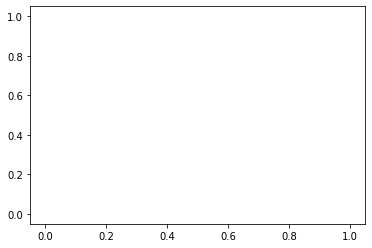

In [ ]:
# plt.plot(nb_fpr, nb_tpr, marker='.', label='Gaussian (AUROC = %0.3f)' % nb_auc)

In [ ]:
# X.shape

(16224, 24000)

In [ ]:
# fpr1, tpr1,thresh1 =roc_curve(y_test, pred_prob1[:,1],pos_label=1)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [ ]:
# tpr1

array([nan, nan, nan])

In [ ]:
# import matplotlib.pyplot as plt

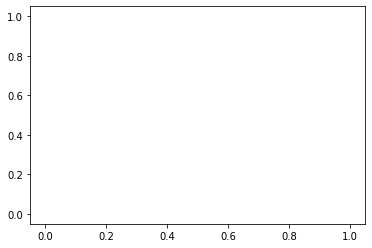

In [ ]:
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Gaussian')